# Goals

In this colab, you will:
*   Learn how to clean up and preprocess genome data
*   Convert genomic data into a feature matrix
*   Build a logistic regression model predicting the country a SARS-CoV-2 lineage came from based on its genome





In [1]:
#@title Set up the notebook
!pip install Biopython
from Bio import SeqIO
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn import model_selection, linear_model

# import gdown
# data_path = 'https://drive.google.com/uc?id=1f1CtRwSohB7uaAypn8iA4oqdXlD_xXL1'
# cov2_sequences = 'SARS_CoV_2_sequences_global.fasta'
# gdown.download(data_path, cov2_sequences, True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20DNA%20Detectives/SARS_CoV_2_sequences_global.fasta'
cov2_sequences = 'SARS_CoV_2_sequences_global.fasta'


     |████████████████████████████████| 2.3MB 7.5MB/s 
--2021-06-17 20:57:36--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20DNA%20Detectives/SARS_CoV_2_sequences_global.fasta
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.197.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46950263 (45M) [application/octet-stream]
Saving to: ‘SARS_CoV_2_sequences_global.fasta’

SARS_CoV_2_sequence 100%[===================>]  44.77M   124MB/s    in 0.4s    

2021-06-17 20:57:36 (124 MB/s) - ‘SARS_CoV_2_sequences_global.fasta’ saved [46950263/46950263]



# Data preprocessing

## Read in and examine the data.

We are going to read in a set of SARS-CoV-2 genomes from around the world. Note that sequence #0 is the "reference sequence"-- one of the original sequences from Wuhan. These global sequences come from the [NCBI database](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-CoV-2,%20taxid:2697049&SLen_i=29000%20TO%2031000&Completeness_s=complete&HostLineage_ss=Homo%20sapiens%20(human),%20taxid:9606).  You can examine the different sequences using the form below.

In [2]:
sequences = [r for r in SeqIO.parse(cov2_sequences, 'fasta')]
sequence_num =  0#@param {type:"integer"}
print(sequences[sequence_num])

ID: NC_045512
Name: NC_045512
Description: NC_045512 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1| complete genome|China
Number of features: 0
Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA')


###**Exercise: How many sequences are there?**

Note: Sequences have been uploaded/stored in a variable called ```sequences```.

In [3]:
print(type(sequences))
n_sequences = len(sequences)
print("There are %f sequences" % n_sequences)

<class 'list'>
There are 1538.000000 sequences


###**Exercise: How different are the 1st (non-reference) and 10th SARS-CoV-2 sequences?**



In [4]:
sequence_1 = np.array(sequences[0])
sequence_10 = np.array(sequences[9])
# Find the length of both sequences
length_sequence_1 = len(sequence_1)
length_sequence_10 = len(sequence_10)
# Find how many bases are the same
n_bases_same = sum(sequence_1 == sequence_10)
# Divide the number of same bases by the total
percent_similarity = n_bases_same/length_sequence_10 * 100
print("Sequence 1 and 10 similarity: %", percent_similarity)

Sequence 1 and 10 similarity: % 99.9765909774939


### **Exercise (BONUS):  Make a histogram of the number of mutations each SARS-CoV-2 sequence has compared to the reference genome.**

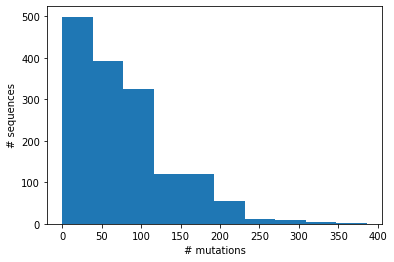

In [5]:
reference = np.array(sequences[0])
mutations_per_seq = np.array([sum(np.array(s) != reference) for s in sequences])

plt.hist(mutations_per_seq)
plt.xlabel('# mutations')
plt.ylabel('# sequences')
plt.show()

for s in sequences:
    mutations_per_seq += np.array([sum(np.array(s) != reference)])

Interestingly, it looks like there are a couple sequences with a LOT of mutations! We can investigate these sequences a little more.

**Examine some of these sequences with high number of mutations by selecting the minimum # of mutations from the form below. What do you notice about the sequences? Discuss with your instructor and peers.**



In [6]:
min_number_of_mutations  =  340#@param {type:"integer"}
idx = np.random.choice(np.where(mutations_per_seq>min_number_of_mutations)[0])
print("Sequence %i has > %.0f mutations! \n" % (idx, min_number_of_mutations))
print(sequences[idx], '\n')
print("The sequence is composed of: ")
Counter(np.array(sequences[idx]))

Sequence 416 has > 340 mutations! 

ID: MT259236
Name: MT259236
Description: MT259236 |Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW244/2020| complete genome|USA
Number of features: 0
Seq('------------------------TAACAAACCTTTAAACTTTCGATCTCTTGT...AAA') 

The sequence is composed of: 


Counter({'-': 24, 'A': 8945, 'C': 5484, 'G': 5860, 'T': 9590})

## Missing Data


It is hard to see, but some of the sequences have `N` in them. Run the cell below for an example

### **Exercise: Calculate the number of sequences that have an ```N``` in them.**

**What do you think ```N``` means?**

In [7]:
n_sequences_with_N = 0
for seq in sequences:
  for nuc in seq:
    if (nuc == "N"):
      n_sequences_with_N += 1
      break
print('%i sequences have at least 1 "N"!' % n_sequences_with_N)

326 sequences have at least 1 "N"!



`N` is not a nucleic acid- it just stands for "missing", or "low quality". "Missing" is different than ```_``` or a deletion. At the locations with ```N```, the sequencing machine had low quality data here, so it was unable to determine what base was at that location. We should remember this when we extact our features. Stay tuned for more on sequencing machines and how sequences are built in the bonus colab of this project!

# Feature Extraction

We are going to build a model that predicts the country a SARS-CoV-2 virus came from based on its genome.

### **Exercise: Recall the structure of machine learning models.** 
**In general what two categories of data do we need to build a supervised machine learning model? What will we use for each category?**


In [8]:
_1_  =  'inputs: genomes of sequences' #@param {type:"string"}
_2_  =  'labels: country that each sequence came from' #@param {type:"string"}

print('1. We need a set of FEATURES (X).\n',
      '  Our features will be the genomes of the different sequences.')
print('2. We need LABElS (Y).\n',
      '  Our labels will be the country that each sequence came from.')


1. We need a set of FEATURES (X).
   Our features will be the genomes of the different sequences.
2. We need LABElS (Y).
   Our labels will be the country that each sequence came from.


**Question: How will we turn our features into a numeric matrix?**

## Extract Features (X)

Remember that our input must be a *numeric* matrix/table.
We are going to create a matrix where our features are the presence/absence of a specific mutation (given by ```<location>```_```<base>```).  

Our columns will be 1_A, 1_T, 3_G, 4_A, etc.


| Sequence ID | 1_A | 1_C | 3_G | 4_A  | ...|
|-------------|-----|-----|-----|------|----|
|Sequence 1   |  1  |  0  |   1 |    0 |  0 |
|Sequence 2   |  0  |  0  |   1 |    0 |  0 |
|Sequence 3   |  1  |  0  |   0 |    0 |  0 |
|Sequence 4   |  0  |  1  |   0 |    1 |  1 |
|Sequence 5   |  1  |  0  |   0 |    0 |  1 |




In [9]:
# Note: This can take a couple minutes to run! 
# but we can monitor our progress using the tqdm library
mutation_df = pd.DataFrame()
n_bases_in_seq = len(sequences[0])

# Iterate though all positions in this sequence.
for location in tqdm.tqdm(range(n_bases_in_seq)): # tqdm is a nice library that prints our progress.
  bases_at_location = np.array([s[location] for s in sequences])
  # If there are no mutations at this position, move on.
  if len(set(bases_at_location))==1: continue # If
  for base in ['A', 'T', 'G', 'C', '-']:
    feature_values = (bases_at_location==base)
    
    # Set the values of any base that equals 'N' to np.nan.
    feature_values[bases_at_location==['N']] = np.nan
    
    # Convert from T/F to 0/1.
    feature_values  = feature_values*1
    
    # Make the column name look like <location>_<base> (1_A, 2_G, 3_A, etc.)
    column_name = str(location) + '_' + base
    mutation_df[column_name] = feature_values

# Print the size of the feature matrix/table.
n_rows = np.shape(mutation_df)[0]
n_columns = np.shape(mutation_df)[1]
print("Size of matrix: %i rows x %i columns" %(n_rows, n_columns))

# Check what the matrix looks like:
mutation_df.tail()

100%|██████████| 29903/29903 [01:10<00:00, 425.40it/s]

Size of matrix: 1538 rows x 12680 columns


,0_A,0_T,0_G,0_C,0_-,1_A,1_T,1_G,1_C,1_-,2_A,2_T,2_G,2_C,2_-,3_A,3_T,3_G,3_C,3_-,4_A,4_T,4_G,4_C,4_-,5_A,5_T,5_G,5_C,5_-,6_A,6_T,6_G,6_C,6_-,7_A,7_T,7_G,7_C,7_-,...,29895_A,29895_T,29895_G,29895_C,29895_-,29896_A,29896_T,29896_G,29896_C,29896_-,29897_A,29897_T,29897_G,29897_C,29897_-,29898_A,29898_T,29898_G,29898_C,29898_-,29899_A,29899_T,29899_G,29899_C,29899_-,29900_A,29900_T,29900_G,29900_C,29900_-,29901_A,29901_T,29901_G,29901_C,29901_-,29902_A,29902_T,29902_G,29902_C,29902_-
1533,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1534,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1535,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1536,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1537,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [10]:
mutation_df.head()

,0_A,0_T,0_G,0_C,0_-,1_A,1_T,1_G,1_C,1_-,2_A,2_T,2_G,2_C,2_-,3_A,3_T,3_G,3_C,3_-,4_A,4_T,4_G,4_C,4_-,5_A,5_T,5_G,5_C,5_-,6_A,6_T,6_G,6_C,6_-,7_A,7_T,7_G,7_C,7_-,...,29895_A,29895_T,29895_G,29895_C,29895_-,29896_A,29896_T,29896_G,29896_C,29896_-,29897_A,29897_T,29897_G,29897_C,29897_-,29898_A,29898_T,29898_G,29898_C,29898_-,29899_A,29899_T,29899_G,29899_C,29899_-,29900_A,29900_T,29900_G,29900_C,29900_-,29901_A,29901_T,29901_G,29901_C,29901_-,29902_A,29902_T,29902_G,29902_C,29902_-
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


## Extract Label (Y)

### We are going to use the region of the world that each sample came from as the **label**. ![alt text](https://upload.wikimedia.org/wikipedia/commons/3/3d/Flag-map_of_the_world_%282017%29.png)

First, let's see how many samples we have from different countries.

In [11]:
#@title ###**Exercise: Explore the different number of samples that come from each country.**
country = "Hong Kong" #@param dict_keys(['China', 'Kazakhstan', 'India', 'Sri Lanka', 'Taiwan', 'Hong Kong', 'Viet Nam', 'Thailand', 'Nepal', 'Israel', 'South Korea', 'Iran', 'Pakistan', 'Turkey', 'Australia', 'USA']
countries = [(s.description).split('|')[-1] for s in sequences]
print("There are %i sequences from %s." %
      (Counter(countries)[country], country))

There are 19 sequences from Hong Kong.


Since some countries only have a couple samples, we are going to use the **region** of the world as our labels. 

Since we have a large number of samples from Asia, North America, and Oceania, we will filter ours sequences to just these regions. We will convert our countries to regions using the code below.

### **Exercise: Convert each country to it's region of the world.** 
**Use the code below to create a dictionary of ```<country>```:```<region>``` where ```region``` is either ```'Oceania'```, ```'North America'```, or ```'Asia'```, and convert each country to region.**

In [12]:
countries_to_regions_dict = {
         'Australia': 'Oceania',
         'China': 'Asia',
         'Hong Kong': 'Asia',
         'India': 'Asia',
         'Nepal': 'Asia',
         'South Korea': 'Asia',
         'Sri Lanka': 'Asia',
         'Taiwan': 'Asia',
         'Thailand': 'Asia',
         'USA': 'North America',
         'Viet Nam': 'Asia',
}

regions = [countries_to_regions_dict[c] if c in 
           countries_to_regions_dict else 'NA' for c in countries]
mutation_df['label'] = regions

**Now see how many samples there are from each region of the world.**

In [13]:
region = "North America" #@param ['Oceania', 'North America', 'Asia']
print("There are %i sequences from %s." %
      (Counter(regions)[region], region))

There are 1215 sequences from North America.


## Balancing the Data


Recall that ML models work the best if we have *balanced* data- a dataset with equal numbers of samples with each label. Run the following code to remove duplicate samples from the dataset, and then balance the samples.

### **Exercise: Balance the data equally between samples from Asia, Oceania, and North America**

In [14]:
balanced_df = mutation_df.copy()
balanced_df['label'] = regions
balanced_df = balanced_df[balanced_df.label!='NA']
balanced_df = balanced_df.drop_duplicates()
samples_north_america = balanced_df[balanced_df.label=='North America']
samples_oceania = balanced_df[balanced_df.label=='Oceania']
samples_asia = balanced_df[balanced_df.label=='Asia']

# Number of samples we will use from each region.
n = min(len(samples_north_america),
       len(samples_oceania),
       len(samples_asia))

balanced_df = pd.concat([samples_north_america[:n],
                    samples_asia[:n],
                    samples_oceania[:n]])
print("Number of samples in each region: ", Counter(balanced_df['label']))

Number of samples in each region:  Counter({'North America': 128, 'Asia': 128, 'Oceania': 128})


# Logistic Regression Model

***Congrats!***  We finally are done with preprocessing/cleaning our data! Although tedious, this is an important part of doing machine learning in biology. The data can be complex and messy, and if we don't do some cleaning up beforehand, our models will have poor performance.


![](https://media.makeameme.org/created/we-did-it-3b3ac27d2a.jpg)


Finally, run the code to set up a ```X``` feature matrix and a ```Y``` label list from our ```balanced_df```. You can explore the different values using the code below:

In [15]:
X = balanced_df.drop('label', 1)
Y = balanced_df.label
data = "X (features)" #@param ['X (features)', 'Y (label)']
start =  1#@param {type:'integer'}
stop =  10#@param {type:'integer'}

if start>=stop:print("Start must be < stop!")
else:
  if data=='X (features)':
    print(X.iloc[start:stop])
  if data=='Y (label)':
    print(Y[start:stop])

     0_A  0_T  0_G  0_C  0_-  ...  29902_A  29902_T  29902_G  29902_C  29902_-
323    1    0    0    0    0  ...        0        0        0        0        1
324    0    0    1    0    0  ...        1        0        0        0        0
325    1    0    0    0    0  ...        0        0        0        0        1
326    1    0    0    0    0  ...        0        0        0        0        1
327    0    0    1    0    0  ...        0        0        0        0        1
328    1    0    0    0    0  ...        0        0        0        0        1
329    1    0    0    0    0  ...        0        0        0        0        1
330    1    0    0    0    0  ...        0        0        0        0        1
331    1    0    0    0    0  ...        0        0        0        0        1

[9 rows x 12680 columns]


## Training

We will be using the logistic regression model we have learned about with one modification. We will use the "multinomial" class of logistic regression model.  This is used when there are more than 2 categories in the label set. In our case, we have ```Asia```, ```North America```, and ```North America``` as our possible labels.

### **Exercise: Train the model using the standard pipeline you have mastered!**

In [22]:
lm = linear_model.LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)

# Split into training/testing set. Use a training size of .8
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

# Train/fit model.
lm.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.001, verbose=0,
                   warm_start=False)

## Testing/Evaluation

In addition to printing the accuracy of a model, we can also use a *confusion matrix* to see how well the model performed.

###**Exercise: Evaluate the model on the test set.**


In [20]:
# Predict on the test set.
Y_pred = lm.predict(X_test)

# Compute accuracy.
accuracy = 100*np.mean(Y_test==Y_pred)
print("Accuracy: %", accuracy)

# Compute confusion matrix.
confusion_mat = pd.DataFrame(confusion_matrix(Y_test, Y_pred))
confusion_mat.columns = [c + ' predicted' for c in lm.classes_]
confusion_mat.index = [c + ' true' for c in lm.classes_]

print(confusion_mat)

Accuracy: % 92.20779220779221
                    Asia predicted  North America predicted  Oceania predicted
Asia true                       25                        1                  3
North America true               2                       21                  0
Oceania true                     0                        0                 25


# Wrapping up

![alt text](https://memecrunch.com/meme/60HHF/done-and-done/image.jpg)

***Great job!*** You built a pretty accurate model that uses genomic data to predict what country a SARS-CoV-2 sample comes from.

In [21]:
#@title #### **Exercise: To wrap up, write a couple of sentences explaining how your model performed.**
Response = "The model performed pretty well, with an accuracy of 93.5%." #@param {type:"string"}
